In [1]:
from MegaSAM.mega_adaptive_sam import MegaSAM
from MegaSAM.data.moons import moons_data_gen
import sys; sys.path.append("..")

sys.path.append("sam")
from sam import SAM

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
from sklearn import datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
N = 1000

all_data, train_loader, test_loader, test_data = moons_data_gen(N=1000, batch_size=1000)

In [4]:
from tqdm.notebook import tqdm, trange

output1 = 10

model = nn.Sequential(
    nn.Linear(2, output1),
    nn.ReLU(),
    nn.Linear(output1, 1)
)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

num_params = get_n_params(model)
M = torch.ones(num_params)

epochs = 1000

base_optimizer = torch.optim.SGD
optimizer = MegaSAM(model.parameters(), base_optimizer, M=M, eta2=0.01, alpha=0.05, lr = 0.01)
criterion = nn.BCEWithLogitsLoss()

for epoch in trange(epochs):
    for points, labels in train_loader:
        
        optimizer.zero_grad()

        x = points[:,:,0].float()
        x = x.to(device)
        labels = labels[:,None].double()

        def closure():
          loss = criterion(model(x), labels)
          loss.backward()
          return loss

        y = model(x)
        loss = criterion(y, labels)
        
        loss.backward()
        optimizer.step(closure)


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\Summer-2022\MegaAdaptiveSAM\MegaSAM\mega_adaptive_sam.py:91: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2985.)
  norm = torch.sqrt(M_inv.T @ grads_flattened**2)


In [5]:
correct_test = 0
with torch.no_grad():
        # Iterate through test set minibatchs 
        for numbers2, labels2 in test_loader:
            numbers2 = numbers2
            labels2 = labels2.double()[:,None]
            # Forward pass
            x2 = numbers2[:,:,0].float()
            y2 = model(x2)
            predictions2 = ((y2>0)*1)
            correct_test += torch.sum((predictions2 == labels2).float())
print(f'Test accuracy: {correct_test/len(test_data)}')

Test accuracy: 0.875


In [6]:
def _flatten_and_together(list_of_tensors):
    new_list = []
    for tensor in list_of_tensors:
        new_list.append(torch.flatten(tensor))
    return torch.cat(new_list)

def calculate_fischer(N, model, test_data):
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
    n_params = get_n_params(model)
    fischer_matrix = torch.zeros((n_params, n_params))
    for datapoints, _ in test_loader:
        #labels = labels.double()[:, None]
        #Forward pass
        x = datapoints[:, :, 0].float()
        y = model(x)
        labels = torch.bernoulli(torch.sigmoid(y.detach()))
        loss_fn = nn.BCEWithLogitsLoss()
        loss = loss_fn(y, labels)
        loss.backward()
        g = _flatten_and_together([p.grad for p in model.parameters()])
        fischer_matrix += g[None, :] * g[:, None]
        fischer_matrix = fischer_matrix / N
        return fischer_matrix

F = calculate_fischer(N, model, test_data)

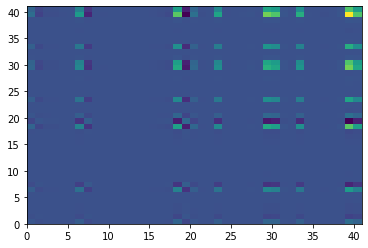

In [7]:
plt.pcolor(F.numpy())

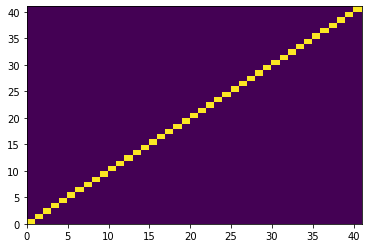

In [10]:
plt.pcolor(np.diag(optimizer.M))

In [8]:
optimizer.M

tensor([1.0380, 1.0381, 1.0382, 1.0384, 1.0389, 1.0398, 1.0380, 1.0381, 1.0381,
        1.0380, 1.0380, 1.0380, 1.0383, 1.0392, 1.0380, 1.0380, 1.0385, 1.0418,
        1.0380, 1.0380, 1.0382, 1.0380, 1.0393, 1.0380, 1.0380, 1.0380, 1.0392,
        1.0380, 1.0393, 1.0380, 1.0392, 1.0383, 1.0432, 1.0388, 1.0380, 1.0380,
        1.0394, 1.0380, 1.0440, 1.0380, 1.0390])